# Full Dataset Training of MNIST

In [1]:
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::#
# Mohit Kumar Ahuja                                                             #
# PhD Student                                                                   #
# Simula Research Laboratory                                                    #
# mohit@simula.no                                                               #
# File: Full Dataset Training of MNIST                                  #
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::#

from __future__ import print_function

import time
from sklearn.metrics import classification_report, confusion_matrix
import os
import datetime
import numpy as np
import keras
#from Functions_Regression_Testing import*
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import mnist
#from Functions_Regression_Testing import*
from keras.models import Sequential

from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

now = datetime.datetime.now
seed = 0
np.random.seed(seed)
    
################################################################################
########################## SOME FUNCTIONS ######################################
################################################################################
def shuffle_Data_2D(X, Y):

    print('shape before shuffling:', X.shape)
    # Shuffling all the Images
    m = X.shape[1]      # number of training examples 
    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:,permutation]
    shuffled_Y = Y[permutation]
    print('shape after shuffling:', shuffled_X.shape)

    return shuffled_X, shuffled_Y

class TimeTestAccHistory(keras.callbacks.Callback):
    def __init__(self, x_test_call, y_test, y_test_call):
        super(TimeTestAccHistory, self).__init__()
        self.x_test_call = x_test_call
        self.y_test = y_test
        self.y_test_call = y_test_call

    def on_train_begin(self, logs={}):
        self.times = []
        self.test_acc = []
        self.avg_conf = []
        self.max_miscl_num = []
        self.conf_class_median = []
        self.std_conf = []
        self.most_conf_class_1 = []
        self.most_conf_class_2 = []
        self.sum_of_confused_classes = []

    def on_epoch_begin(self, batch, logs={}):
        self.start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.start)        
        test_accuracy = self.model.evaluate(self.x_test_call, self.y_test_call)
        self.test_acc.append(test_accuracy[1])
        
        rounded_pred_call = self.model.predict_classes(self.x_test_call, batch_size = 32, verbose = 0)
        cm = confusion_matrix(rounded_pred_call, self.y_test)
        np.fill_diagonal(cm, 0)
        Total_misclassified_images = cm.sum()
        self.sum_of_confused_classes.append(Total_misclassified_images)
        
        percentage = self.y_test_call.shape[1] / 10
        remaining = (self.y_test_call.shape[1] - np.int(percentage))*10
        Average_Confusion = Total_misclassified_images/remaining
        self.avg_conf.append(Average_Confusion)
        
        maximum_misclassified_images = cm.max()
        self.max_miscl_num.append(maximum_misclassified_images)
        
        confused_classes=[]
        for i in range(len(cm)):
            for j in range (len(cm)):
                if i != j and cm[i,j] >= maximum_misclassified_images:
                    #print('Class ' + str(i) + ' and Class ' + str(j) + ' have high confusion rate')
                    confused_classes.append(i)
                    confused_classes.append(j)
                    
        self.most_conf_class_1.append(confused_classes[0])
        self.most_conf_class_2.append(confused_classes[1])
        
        con_median = np.median(cm)
        self.conf_class_median.append(con_median)
        
        std_conf = np.std(cm)
        self.std_conf.append(std_conf)
        
        
        
        
def train_model_mnist_call(model, train, val, test, num_classes, input_shape, batch_size, epochs, lr, callbacks, time_history, mode, hist_csv_file):
    x_train = train[0].reshape((train[0].shape[0],) + input_shape)
    Dev_X = val[0].reshape((val[0].shape[0],) + input_shape)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    x_train = x_train.astype('float32')
    Dev_X = Dev_X.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    #print('x_train shape:', x_train.shape)
    #print('Dev_X Shape:', Dev_X.shape)
    #print("X_test Shape:", x_test.shape)
    #print(x_train.shape[0], 'train samples')
    #print(Dev_X.shape[0], 'validation samples')
    #print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(train[1], num_classes)
    Dev_Y = keras.utils.to_categorical(val[1], num_classes)
    y_test = keras.utils.to_categorical(test[1], num_classes)

    optimizer = keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='categorical_crossentropy',
                  optimizer = optimizer,
                  metrics=['accuracy'])

    t = now()
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(Dev_X, Dev_Y), callbacks = callbacks)
    history.history['time'] = time_history.times
    history.history['test_acc'] = time_history.test_acc
    history.history['avg_conf'] = time_history.avg_conf
    history.history['max_miscl_num'] = time_history.max_miscl_num
    history.history['conf_class_median'] = time_history.conf_class_median
    history.history['std_conf'] = time_history.std_conf
    history.history['most_conf_class_1'] = time_history.most_conf_class_1
    history.history['most_conf_class_2'] = time_history.most_conf_class_2
    history.history['sum_of_confused_classes'] = time_history.sum_of_confused_classes
    
    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history)
    with open(hist_csv_file, mode=mode, newline = '\n') as f:
        #print(hist_df.head())
        hist_df.to_csv(f, index= False, header=mode=='w')
    
    print("*******************************************")
    print('Training time: %s' % (now() - t))
    #print('x_test shape:', x_test.shape)
    #print('y_test shape:', y_test.shape)
    score = model.evaluate(x_test, y_test, verbose=0)
    print("*******************************************")
    #print('Test score:', score[0])
    print('Test accuracy:', score[1])
    print("*******************************************")
    
################################################################################
#################################  CODE  #######################################
################################################################################

Using TensorFlow backend.


In [2]:
from apricot import FeatureBasedSelection
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from apricot import FacilityLocationSelection

In [3]:
batch_size = 128
num_classes = 10
epochs = 20
hist_csv_file = 'history_MNIST_FULL_TRAINING.csv'


# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
filters = 32
# size of pooling area for max pooling
pool_size = 2
# convolution kernel size
kernel_size = 3

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)

    
#######################################################################
# MNIST Load data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'MNIST_FULL_%s_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

input_shape = (x_test.shape[1], x_test.shape[2], 1)
x_test_call = x_test.reshape((x_test.shape[0],) + input_shape)
print("X_test shape = ", x_test_call.shape)
y_test_call = keras.utils.to_categorical(y_test, num_classes)
print("Y_test shape = ", y_test.shape)
print("Y_test_call shape = ", y_test_call.shape)

time_history = TimeTestAccHistory(x_test_call, y_test, y_test_call)
callbacks = [checkpoint, time_history]

#######################################################################
# Reshaping it to (60000,784)
X_train_flatten = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
X_train_flatten = np.transpose(X_train_flatten)

# Shuffling Data
S_X, S_Y = shuffle_Data_2D(X_train_flatten, y_train)

# Creating a train set from the training data
x_train = S_X[:,0:40000]
y_train = S_Y[0:40000]

# Creating a Validation set for training
Dev_X = S_X[:,40000:]
Dev_Y = S_Y[40000:]

x_train=np.transpose(x_train)
Dev_X=np.transpose(Dev_X)
x_train=x_train.reshape((x_train.shape[0], 28, 28))
Dev_X=Dev_X.reshape((Dev_X.shape[0], 28, 28))

##########################################################################
# define two groups of layers: feature (convolutions) and classification (dense)
feature_layers = [
    Conv2D(filters, kernel_size,
           padding='valid',
           input_shape=input_shape),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    Flatten(),
]

classification_layers = [
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_classes),
    Activation('softmax')
]

############################################################################
# TRAINING
############################################################################
# create complete model
model = Sequential(feature_layers + classification_layers)

# train model
train_model_mnist_call(model,(x_train, y_train),(Dev_X, Dev_Y), (x_test, y_test), 
                  num_classes, input_shape, batch_size, epochs=epochs, lr=0.001, 
                  callbacks=callbacks, time_history = time_history, mode='w', 
                  hist_csv_file = hist_csv_file)

############################################################################
print("Training FINISHED")
##################################################################################

X_test shape =  (10000, 28, 28, 1)
Y_test shape =  (10000,)
Y_test_call shape =  (10000, 10)
shape before shuffling: (784, 60000)
shape after shuffling: (784, 60000)
Train on 40000 samples, validate on 20000 samples
Epoch 1/20
40000/40000 [==============================] - 10s 254us/step - loss: 0.3549 - acc: 0.8905 - val_loss: 0.4667 - val_acc: 0.9707

Epoch 00001: val_acc improved from -inf to 0.97070, saving model to C:\Users\mohit\Desktop\survey paper\Metamorphic Test\saved_models\MNIST_FULL_%s_model.001.h5
10000/10000 [==============================] - 1s 92us/step
Epoch 2/20
40000/40000 [==============================] - 7s 179us/step - loss: 0.1172 - acc: 0.9646 - val_loss: 0.3210 - val_acc: 0.9797

Epoch 00002: val_acc improved from 0.97070 to 0.97965, saving model to C:\Users\mohit\Desktop\survey paper\Metamorphic Test\saved_models\MNIST_FULL_%s_model.002.h5
10000/10000 [==============================] - 1s 87us/step
Epoch 3/20
40000/40000 [==============================] - 7s

In [5]:
data = pd.read_csv(hist_csv_file)
print(data.shape)
data.head()

(20, 13)


,val_loss,val_acc,loss,acc,time,test_acc,avg_conf,max_miscl_num,conf_class_median,std_conf,most_conf_class_1,most_conf_class_2,sum_of_confused_classes
0,0.466731,0.97070,0.354888,0.890525,10.681741,0.9744,2.844444,18,1.0,3.553365,3,5,256
1,0.320961,0.97965,0.117235,0.964550,7.167869,0.9796,2.266667,11,1.0,2.770993,8,3,204
2,0.240816,0.98485,0.087220,0.973625,7.127975,0.9850,1.666667,10,0.5,1.992486,2,7,150
3,0.221709,0.98600,0.068922,0.979300,6.702079,0.9864,1.511111,9,0.5,1.972410,2,7,136
4,0.307999,0.98075,0.060784,0.981975,6.702080,0.9812,2.088889,19,0.0,3.677717,8,2,188


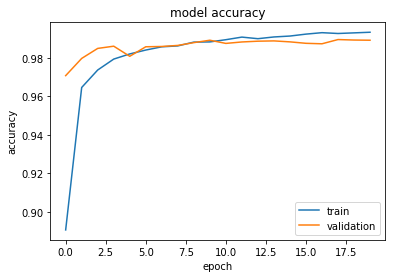

In [6]:
#  "Accuracy"
plt.plot(data['acc'])
plt.plot(data['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

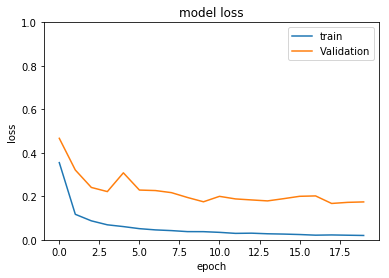

In [7]:
# "Loss"
plt.plot(data['loss'])
plt.plot(data['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'])
plt.ylim(0,1)
plt.show()

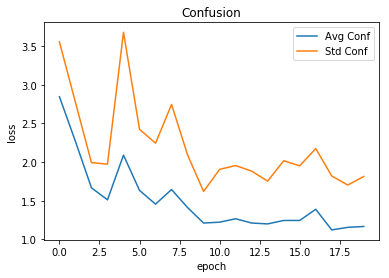

In [8]:
#  "Average Confustion"
plt.plot(data['avg_conf'])
plt.plot(data['std_conf'])
plt.title('Confusion')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Avg Conf', 'Std Conf'], loc='upper right')
plt.show()


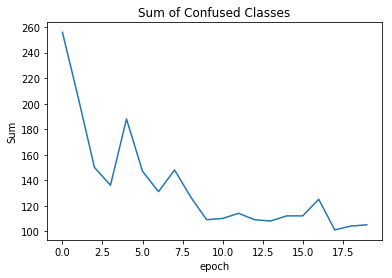

In [9]:
#   "sum_of_confused_classes"
plt.plot(data['sum_of_confused_classes'])
plt.title('Sum of Confused Classes')
plt.ylabel('Sum')
plt.xlabel('epoch')
#plt.legend(['Avg Conf', 'Std Conf'], loc='upper right')
plt.show()

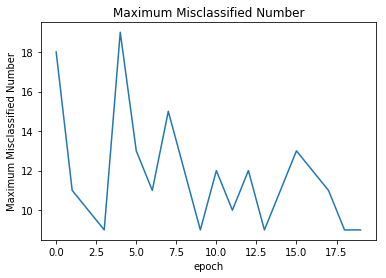

In [10]:
#   "Max Misclassified"
plt.plot(data['max_miscl_num'])
plt.title('Maximum Misclassified Number')
plt.ylabel('Maximum Misclassified Number')
plt.xlabel('epoch')
#plt.legend(['Avg Conf', 'Std Conf'], loc='upper right')
plt.show()